In [98]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight

In [84]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [8]:
# --- Step 1: Download Dataset from Kaggle ---
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jlexzhong/mineral-microscopic-image-dataset

Dataset URL: https://www.kaggle.com/datasets/jlexzhong/mineral-microscopic-image-dataset
License(s): unknown
mineral-microscopic-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
import zipfile
with zipfile.ZipFile("/content/mineral-microscopic-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("mineral-microscopic-image-dataset")

In [99]:
# --- Step 2: Load and Translate Labels ---
# Define translation dictionary for Chinese mineral names to English
label_translation = {
    '十字石': 'Staurolite',
    '斜长石': 'Plagioclase',
    '普通辉石': 'Pyroxene',
    '橄榄石': 'Olivine',
    '石榴子石': 'Garnet',
    '红柱石': 'Andalusite',
    '角闪石': 'Hornblende',
    '鲕粒': 'Epidote'
}

# Hardcode the Chinese folder names to match the dataset structure
chinese_folders = [
    '十字石', '斜长石', '普通辉石', '橄榄石',
    '石榴子石', '红柱石', '角闪石', '鲕粒'
]

data = []
labels = []

# Dataset path
data_path = '/content/mineral-microscopic-image-dataset/scidb_data'
# Use scandir to safely iterate over directory contents
for entry in os.scandir(data_path):
    if entry.is_dir():
        try:
            # Attempt to decode the folder name as UTF-8
            folder_name = entry.name.encode().decode('utf-8')
            if folder_name in chinese_folders:
                translated = label_translation[folder_name]
                class_path = os.path.join(data_path, folder_name)
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    data.append(img_path)
                    labels.append(translated)
        except UnicodeDecodeError:
            continue  # Skip if decoding fails

# Create DataFrame
df = pd.DataFrame({'image_path': data, 'label': labels})
print("Dataset loaded. Number of images:", len(df))
print("Classes found:", df['label'].unique())

Dataset loaded. Number of images: 671
Classes found: ['Andalusite' 'Pyroxene' 'Olivine' 'Hornblende' 'Garnet' 'Plagioclase'
 'Staurolite' 'Epidote']


In [100]:
# --- Step 3: Preprocessing ---
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

img_size = (128, 128)
batch_size = 16
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 536 validated image filenames belonging to 8 classes.
Found 135 validated image filenames belonging to 8 classes.


In [101]:
# --- Step 4: Build Simplified Custom CNN Model ---
num_classes = len(le.classes_)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(*img_size, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │     8,388,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,390,216 (32.01 MB)

 Trainable params: 8,390,152 (32.01 MB)

 Non-trainable params: 64 (256.00 B)

In [102]:
# --- Step 5: Train Model ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.2921 - loss: 3.0981

34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 557ms/step - accuracy: 0.2946 - loss: 3.0802 - val_accuracy: 0.3407 - val_loss: 1.8257 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6430 - loss: 1.2617

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 509ms/step - accuracy: 0.6437 - loss: 1.2588 - val_accuracy: 0.5704 - val_loss: 1.6166 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 529ms/step - accuracy: 0.7865 - loss: 0.6978 - val_accuracy: 0.4148 - val_loss: 1.6202 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8598 - loss: 0.4746

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 523ms/step - accuracy: 0.8598 - loss: 0.4753 - val_accuracy: 0.5630 - val_loss: 1.3752 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8801 - loss: 0.5807

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 497ms/step - accuracy: 0.8808 - loss: 0.5771 - val_accuracy: 0.6741 - val_loss: 1.1830 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8913 - loss: 0.3626

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step - accuracy: 0.8916 - loss: 0.3621 - val_accuracy: 0.8741 - val_loss: 0.8173 - learning_rate: 1.0000e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 488ms/step - accuracy: 0.9361 - loss: 0.2781 - val_accuracy: 0.6889 - val_loss: 0.9380 - learning_rate: 1.0000e-04
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 510ms/step - accuracy: 0.9173 - loss: 0.3131 - val_accuracy: 0.7111 - val_loss: 0.8930 - learning_rate: 1.0000e-04
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9318 - loss: 0.3872

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 508ms/step - accuracy: 0.9319 - loss: 0.3888 - val_accuracy: 0.8222 - val_loss: 0.5821 - learning_rate: 1.0000e-04
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 512ms/step - accuracy: 0.9542 - loss: 0.1821 - val_accuracy: 0.7259 - val_loss: 0.7617 - learning_rate: 1.0000e-04
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9575 - loss: 0.1496

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 510ms/step - accuracy: 0.9575 - loss: 0.1495 - val_accuracy: 0.8074 - val_loss: 0.5508 - learning_rate: 1.0000e-04
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9478 - loss: 0.4049

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 516ms/step - accuracy: 0.9482 - loss: 0.4007 - val_accuracy: 0.8222 - val_loss: 0.4136 - learning_rate: 1.0000e-04
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9735 - loss: 0.0735

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 513ms/step - accuracy: 0.9735 - loss: 0.0734 - val_accuracy: 0.8444 - val_loss: 0.3644 - learning_rate: 1.0000e-04
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 496ms/step - accuracy: 0.9605 - loss: 0.1103 - val_accuracy: 0.8222 - val_loss: 0.7101 - learning_rate: 1.0000e-04
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9670 - loss: 0.1502

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 511ms/step - accuracy: 0.9670 - loss: 0.1497 - val_accuracy: 0.8889 - val_loss: 0.3332 - learning_rate: 1.0000e-04
Epoch 16/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 504ms/step - accuracy: 0.9954 - loss: 0.0387 - val_accuracy: 0.9259 - val_loss: 0.3556 - learning_rate: 1.0000e-04
Epoch 17/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9851 - loss: 0.0369

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.9851 - loss: 0.0368 - val_accuracy: 0.9259 - val_loss: 0.2696 - learning_rate: 1.0000e-04
Epoch 18/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 502ms/step - accuracy: 0.9761 - loss: 0.1739 - val_accuracy: 0.8963 - val_loss: 0.4400 - learning_rate: 1.0000e-04
Epoch 19/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 496ms/step - accuracy: 0.9829 - loss: 0.0784 - val_accuracy: 0.9037 - val_loss: 0.4304 - learning_rate: 1.0000e-04
Epoch 20/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step - accuracy: 0.9901 - loss: 0.0526 - val_accuracy: 0.8963 - val_loss: 0.4438 - learning_rate: 1.0000e-04
Epoch 21/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.9793 - loss: 0.0522 - val_accuracy: 0.9185 - val_loss: 0.2723 - learning_rate: 3.0000e-05
Epoch 22/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9867 - loss: 0.0483

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 520ms/step - accuracy: 0.9868 - loss: 0.0478 - val_accuracy: 0.9111 - val_loss: 0.2194 - learning_rate: 3.0000e-05
Epoch 23/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 499ms/step - accuracy: 0.9873 - loss: 0.0612 - val_accuracy: 0.9333 - val_loss: 0.2950 - learning_rate: 3.0000e-05
Epoch 24/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 497ms/step - accuracy: 0.9952 - loss: 0.0070 - val_accuracy: 0.9259 - val_loss: 0.3125 - learning_rate: 3.0000e-05
Epoch 25/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.9957 - loss: 0.0122 - val_accuracy: 0.9333 - val_loss: 0.3132 - learning_rate: 3.0000e-05
Epoch 26/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 503ms/step - accuracy: 0.9961 - loss: 0.0117 - val_accuracy: 0.9185 - val_loss: 0.3401 - learning_rate: 9.0000e-06
Epoch 27/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 506ms/step - accuracy: 0.9953 - loss: 0.0064 - val_accuracy: 0.9185 - val_loss: 0.3212 - learning_rate: 9.0000e-06
Epoch 28/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 494ms/step - accuracy

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step

Classification Report:
              precision    recall  f1-score   support

  Andalusite       0.89      1.00      0.94         8
     Epidote       1.00      0.89      0.94         9
      Garnet       1.00      1.00      1.00         5
  Hornblende       1.00      1.00      1.00        21
     Olivine       0.81      0.81      0.81        27
 Plagioclase       0.88      0.96      0.92        23
    Pyroxene       0.90      0.87      0.88        30
  Staurolite       1.00      0.92      0.96        12

    accuracy                           0.91       135
   macro avg       0.94      0.93      0.93       135
weighted avg       0.91      0.91      0.91       135



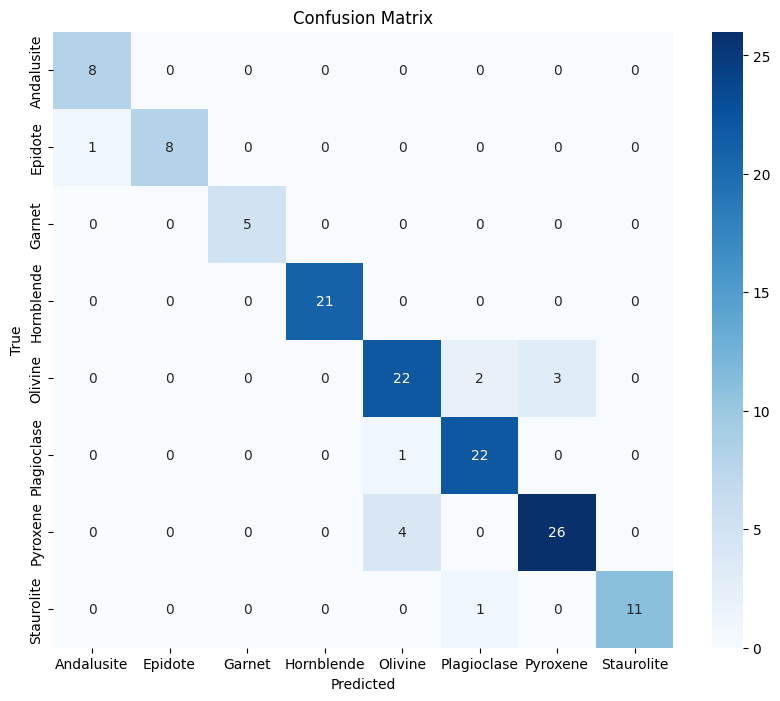

In [103]:
# --- Step 6: Evaluate Model ---
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = le.transform(val_df['label'])

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

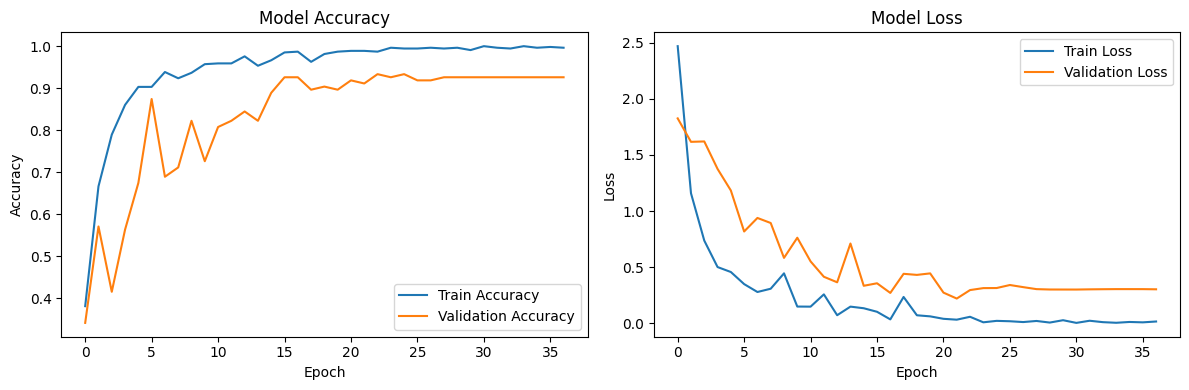

In [104]:
# --- Step 7: Plot Training History ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(acc, label='Train Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(loss, label='Train Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()